# Programa Holt-Winters 

(en los videos viene Holt. A ese código agrégale la s) y aplícalo a algun conjunto de datos de los vistos anteriormente

- Programa este método. Para los primeros L periodos, 𝑠𝑡=1.

- Grafica st, bt, ℓ𝑡.

- Pregunta: ¿cómo se hace forecasting con este método? (hint: la respuesta contiene un "módulo L").

- Mide el error.

In [102]:
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv('/content/macrodata.csv', index_col="Unnamed: 0", parse_dates=True)
#df = pd.read_csv('/content/daily-min-temperatures.csv', index_col='Date', parse_dates=True)


df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [104]:
len(df)

203

In [105]:
def error_rmse(df, colA, colB, init_step): 
    """Función para calcular el error rmse
    """
    valid_df = df[init_step:]
    return np.sqrt(np.mean(np.square(valid_df[colA] - valid_df[colB])))


In [106]:
def error_l1(df, colA, colB, init_step): 
    """Función para calcular el error l1
    """
    valid_df = df[init_step:]
    return np.mean(np.abs(valid_df[colA] - valid_df[colB]))

# Método de Holt-Winters

¿Cuál es el problema de EWMA? Imaginemos que los valores fueran creciendo constantemente. Sería razonable pensar que seguirá creciendo. EWMA siempre predice más pequeños que el último, porque es simplemente un promedio pesado. Vamos entonces a usar una componente de "tendencia" $b_{t}$, en donde simplemente mediremos qué tanto van creciendo o disminuyendo los valores _(método de Holt)_. <- **Método de Holt**

Posteriormente le agregaremos una componente de "periodicidad" $s_{t}$ (seasonality), en donde tomaremos en cuenta los valores del periodo anterior para modelar los ciclos que vemos. 

En resumen, usamos 3 componentes: 

1. $\ell_{t}$ para el "nivel" (EWMA básicamente) 
2. $b_{t}$ para la tendencia
3. $s_{t}$ para la periodicidad 

Cada uno tendrá su parámentro de suavizado: $\alpha, \beta, \gamma$

> Vamos a hacer un EWMA para los tres, de ahí que cada uno tenga su parámetro de suavizado

Primero veremos una versión más sencilla, el método de Holt, donde solo tomamos en cuenta $\ell$ y $b$.

# Método de Holt 

En EWMA teníamos: 

$$y_{1} = x_{0}$$
$$y_{n} = \alpha x_{n-1} + (1-\alpha)y_{n-1}$$

Para tomar en cuenta la tendencía, debemos medir cómo va cambiando el nivel en cada medición y tomaremos el promedio de éstos: 

$$\ell_{t} = (1 - \alpha)\ell_{t-1} + \alpha x_{t}$$
$$b_{t} = (1 - \beta)b_{t-1} + \beta(\ell_{t} - \ell_{t-1})$$
$$y_{t} = \ell_{t} + b_{t}$$

> $\ell_{t}$ es lo que antes era $y$

> en $b_{t}$ (tendecia) estamos comparando los niveles contra los anteriores para ver como va cambiando entre cada tiempo y el siguiente tiempo. Y tomamos un promedio pesado, un promedio con EWMA, tenemos que hacer lo que dicta la formula. 

Si bien para esta actividad debemos agregar la $s$ a este método, entonces nos quedaría de la siguiente manera: 

$$
s_{t} = (1- \gamma)s_{t-1} + \gamma(b_{t} - b_{t-1})
$$
$$
y_{t} = \ell_{t} + b_{t} * s_{t}
$$

# Programa este método. Para los primeros L periodos, 𝑠𝑡=1.


In [107]:
def holts(X, alpha, beta, gamma, L, data):
  """
  INPUT
  ---------------
  X = serie
  alpha = float
  beta = float
  gamma = float
  L = Int
  data = pd.DataFrame

  RETURN
  ------------
  Y = result holt-winters
  data _ pd.DataFrame
  """
  n = len(X)
  l = [X[0]]
  B = [0]
  S = [0]*L
  Y = [X[0]]
  for i in range(1, n): 
    li = alpha*X[i] + (1-alpha)*l[i-1]
    l.append(li)
    bi = (1-beta)*B[-1] + beta*(l[i] - l[i-1])
    B.append(bi)

    # Contabilizar periodos
    if i >= L:
      si = (1-gamma)*S[i-L] + gamma*(B[i] - B[i-1])
      S.append(si)

      yi = li + bi * si
      Y.append(yi)
    else: 
      yi = li + bi * S[i]
      Y.append(yi)
    

  data["St"] = S
  data["Bt"] = B
  data["Lt"] = L
  return (Y, data)

In [108]:
df['Holt_temps'], our_data = holts(df['realgdp'], 0.1, 0.2, 1, 10, df.copy())
#df['Holt_temps'], our_data = holts(df['Temp'], 0.1, 0.2, 1, 10, df.copy())

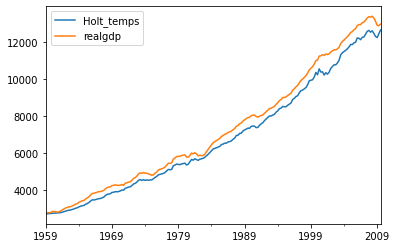

In [109]:
df[['Holt_temps', 'realgdp']].plot()
#df[['Holt_temps', 'Temp']][100:600].plot()

# Mide el error

In [110]:
error_rmse(df, 'realgdp', 'Holt_temps', 100)
#error_rmse(df, 'Temp', 'Holt_temps', 3285)

626.3060589386708

In [111]:
error_l1(df, 'realgdp', 'Holt_temps', 100)
#error_rmse(df, 'Temp', 'Holt_temps', 3285)

604.2422831953655

# Grafica st, bt, ℓ𝑡.

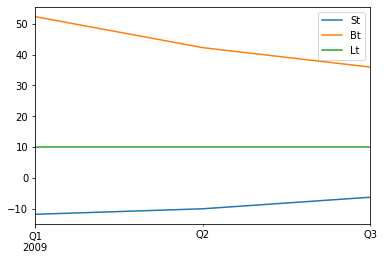

In [112]:
our_data[["St", "Bt", "Lt"]][200:400].plot()

# ¿cómo se hace forecasting con este método? (hint: la respuesta contiene un "módulo L")